In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [2]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = dict()
    att = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        if m == 'BirdFluxGraphLSTM':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att

In [29]:
def plot_fluxes(voronoi, G, fluxes, results, trial=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f for f in fluxes[0].values()], dim=-1)
    mask = np.concatenate([results['BirdFluxGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results['BirdFluxGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            if f[i,j].mean() != 0:
                val = f[j,i,mask].mean().detach().numpy()
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
    cmap = cm.get_cmap('YlOrBr')
    edge_widths = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths /= 0.25 * edge_widths.max()
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    fig, ax = plt.subplots(figsize=(10,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})
    ax.set(title='averaged inferred fluxes between radars');
    return G_new

In [4]:
def plot_sensitivity(results, sigmas, m):
    rmse = []
    for r in results:
        rmse.append(r[m].groupby('trial').error.aggregate(np.nanmean).apply(np.sqrt).values)
    rmse = np.stack(rmse)
    fig, ax = plt.subplots()
    ax.plot(sigmas, rmse.mean(1), '-o', label='perturbed BirdFluxGraphLSTM')
    ax.fill_between(sigmas, rmse.mean(1) - rmse.std(1), rmse.mean(1) + rmse.std(1), alpha=0.2)
    ref_rmse = results[0]['LocalLSTM'].groupby('trial').error.aggregate(np.nanmean).apply(np.sqrt).values
    ax.plot(sigmas, [ref_rmse.mean()] * len(sigmas), label='LocalLSTM')
    ax.fill_between(sigmas, [ref_rmse.mean() - ref_rmse.std()] * len(sigmas), [ref_rmse.mean() + ref_rmse.std()] * len(sigmas), alpha=0.2)
    ax.set(xlabel='perturbation std [birds/km2]', ylabel='RMSE')
    ax.legend()
    return fig

In [5]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values

In [63]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary, bird_scales_fixed_boundary, fluxes_fixed_boundary, _ = load_results(models, experiments, base_dir)

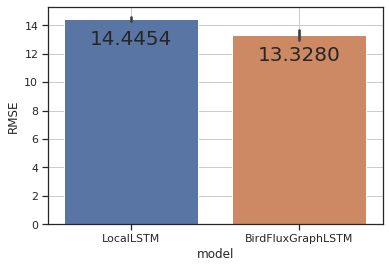

In [80]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.2)$

In [76]:
print(f'std of 0.2 means std of {0.2 * 293} birds/km2')

std of 0.2 means std of 58.6 birds/km2


In [99]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std02, _, fluxes_fixed_boundary_std02, _ = load_results(models, experiments, base_dir)

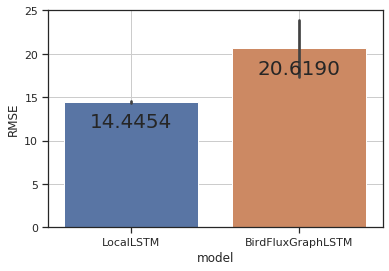

In [100]:
fig = utils.plot_average_errors(results_fixed_boundary_std02, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.15)$

In [109]:
print(f'std of 0.15 means std of {0.15 * 293} birds/km2')

std of 0.15 means std of 43.949999999999996 birds/km2


In [107]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std015, _, fluxes_fixed_boundary_std015, _ = load_results(models, experiments, base_dir)

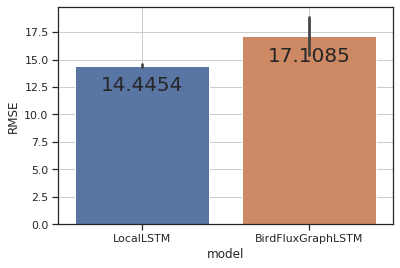

In [108]:
fig = utils.plot_average_errors(results_fixed_boundary_std015, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.1)$

In [78]:
print(f'std of 0.1 means std of {0.1 * 293} birds/km2')

std of 0.1 means std of 29.3 birds/km2


In [110]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std01, _, fluxes_fixed_boundary_std01, _ = load_results(models, experiments, base_dir)

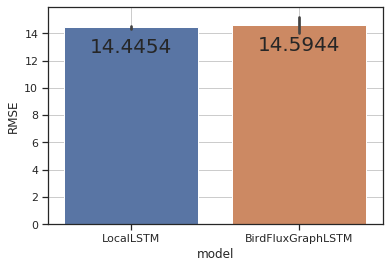

In [111]:
fig = utils.plot_average_errors(results_fixed_boundary_std01, boundary=boundary, night_only=True)

### Random perturbations on boundary radars with $\mathcal{N}(\mu=0, \sigma=0.05)$

In [79]:
print(f'std of 0.05 means std of {0.05 * 293} birds/km2')

std of 0.05 means std of 14.65 birds/km2


In [105]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'fixed_boundary_with_h_j']
results_fixed_boundary_std005, _, fluxes_fixed_boundary_std005, _ = load_results(models, experiments, base_dir)

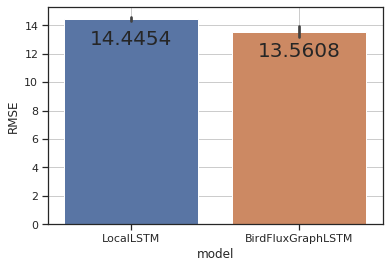

In [106]:
fig = utils.plot_average_errors(results_fixed_boundary_std005, boundary=boundary, night_only=True)

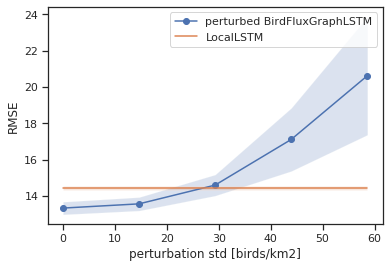

In [134]:
bird_scale = 293
fig = plot_sensitivity([results_fixed_boundary,
                 results_fixed_boundary_std005,
                 results_fixed_boundary_std01,
                 results_fixed_boundary_std015,
                 results_fixed_boundary_std02],
                 np.array([0, 0.05, 0.1, 0.15, 0.2]) * bird_scale, 'BirdFluxGraphLSTM')
fig.savefig('/home/fiona/birdMigration/data/plots/BirdFluxGraphLSTM/sensitivity_to_boundary.png', bbox_inches='tight', dpi=300)

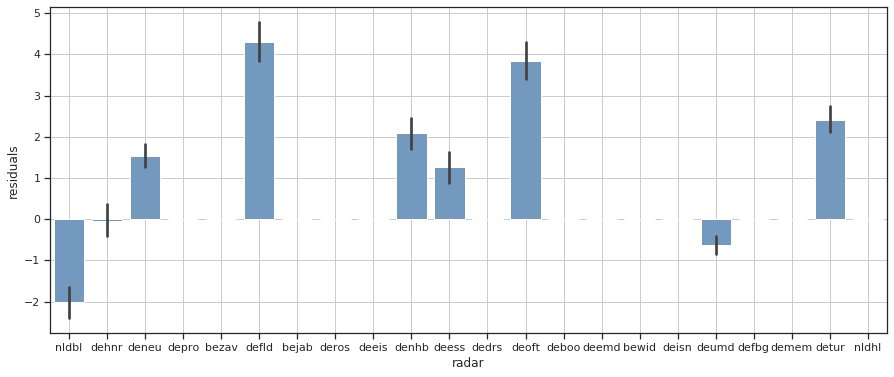

In [33]:
fig = utils.plot_errors_per_radar(results_fixed_boundary, 'BirdFluxGraphLSTM')

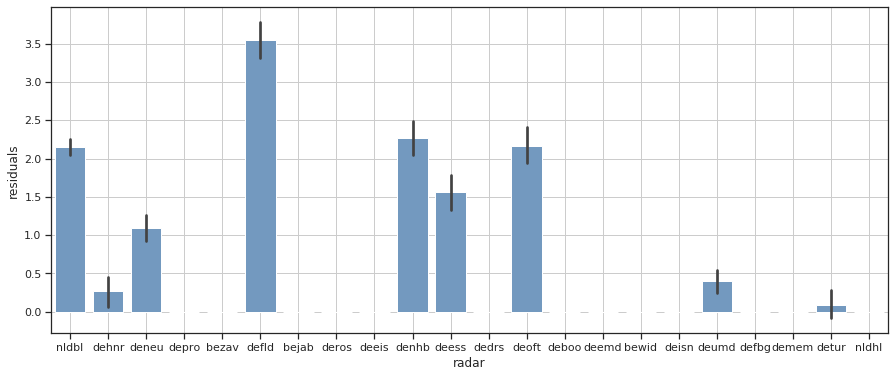

In [26]:
fig = utils.plot_errors_per_radar(results_boundary_fluxmlp, 'BirdFluxGraphLSTM')

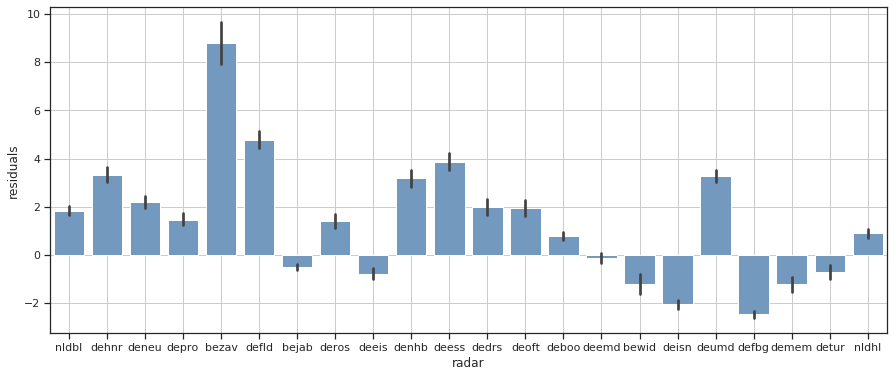

In [27]:
fig = utils.plot_errors_per_radar(results_boundary_lstm, 'BirdFluxGraphLSTM')

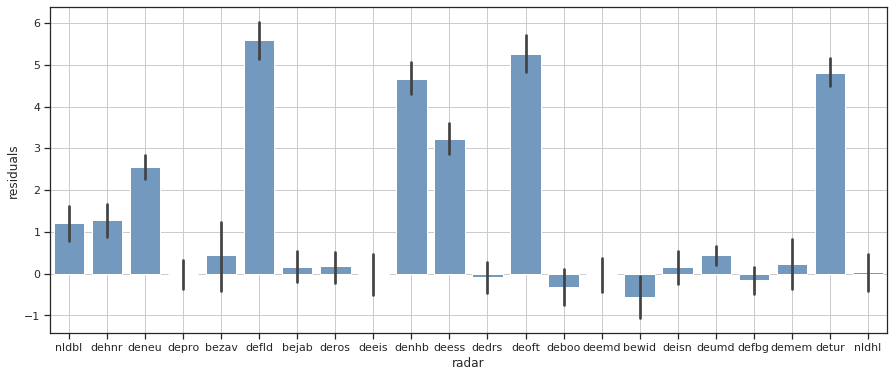

In [39]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std005, 'BirdFluxGraphLSTM')

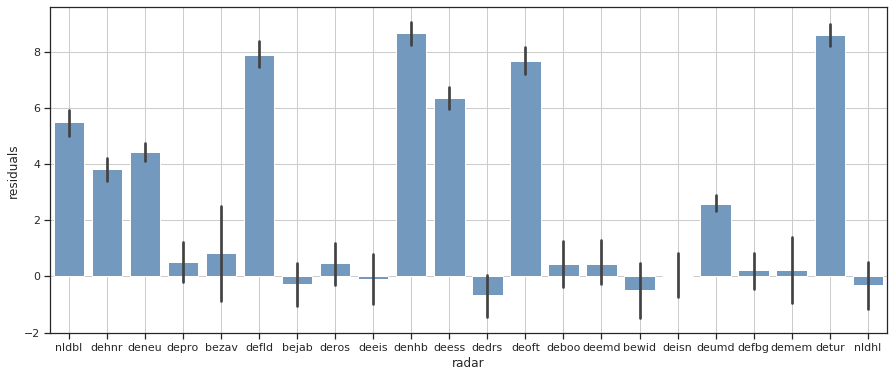

In [28]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std01, 'BirdFluxGraphLSTM')

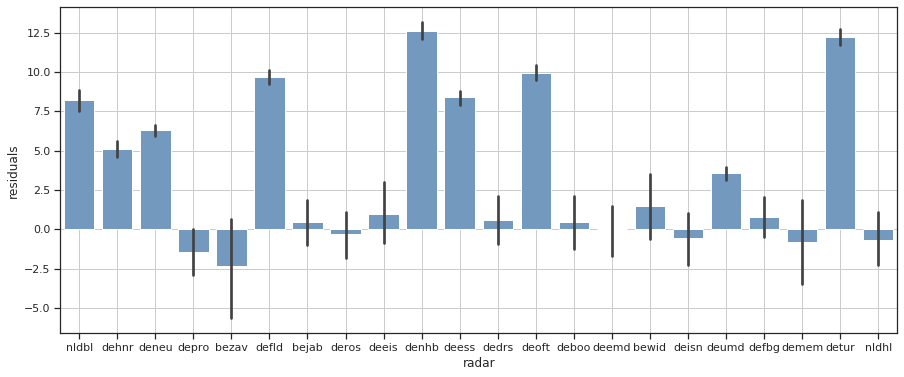

In [36]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_std02, 'BirdFluxGraphLSTM')

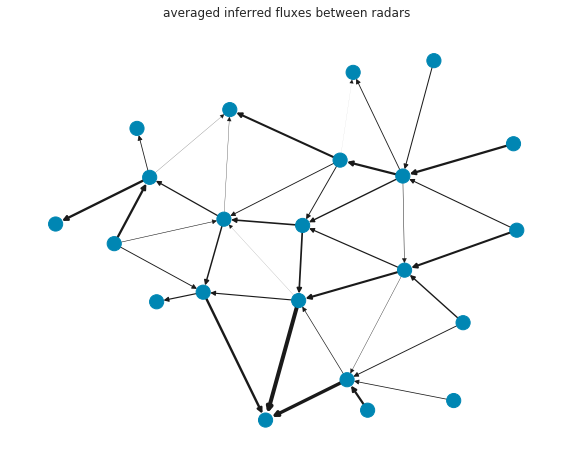

In [10]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

plot_fluxes(voronoi, G, fluxes_fixed_boundary, results_fixed_boundary, trial=0)

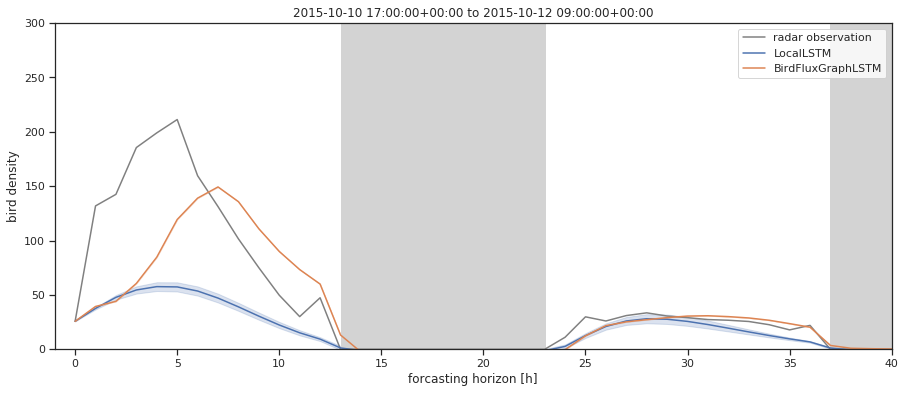

In [44]:
fig = utils.plot_example_prediction(results_fixed_boundary, 'denhb', 44, max=300)

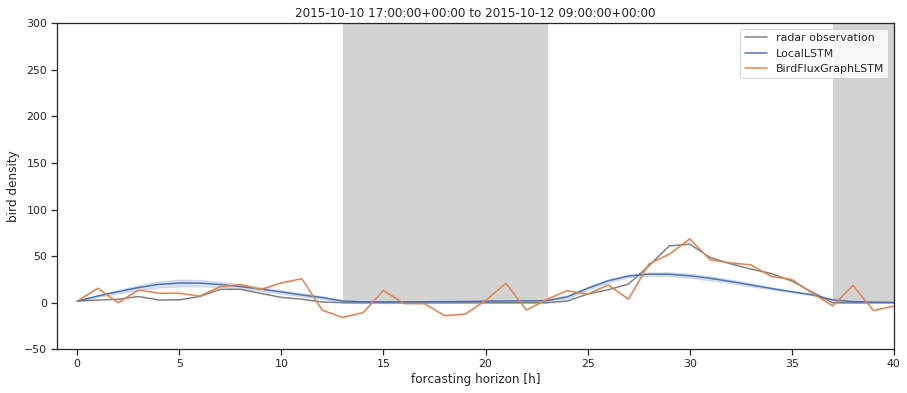

In [49]:
fig = utils.plot_example_prediction(results_fixed_boundary_std005, 'defbg', 44, max=300, min=-50)

In [7]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_lstm_without_dummy_radars']
results_boundary_lstm, bird_scales_boundary_lstm, fluxes_boundary_lstm, _ = load_results(models, experiments, base_dir)

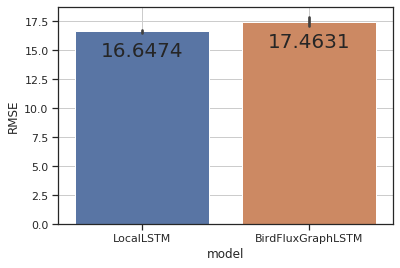

In [14]:
fig = utils.plot_average_errors(results_boundary_lstm, boundary=[], night_only=True)

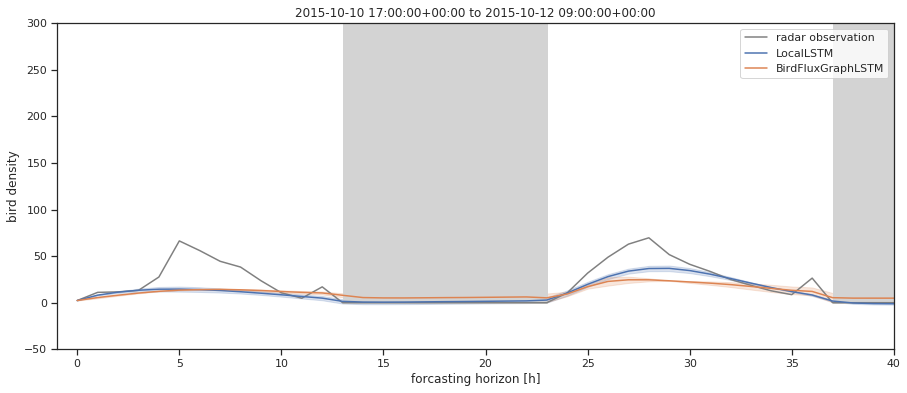

In [20]:
fig = utils.plot_example_prediction(results_boundary_lstm, 'detur', 44, max=300, min=-50)

In [21]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'boundary_fluxmlp_without_dummy_radars']
results_boundary_fluxmlp, bird_scales_boundary_fluxmlp, fluxes_boundary_fluxmlp, _ = load_results(models, experiments, base_dir)

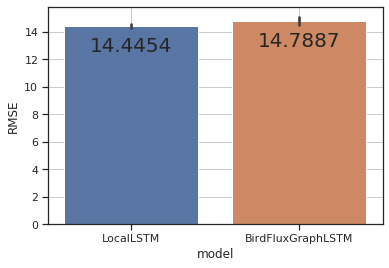

In [22]:
fig = utils.plot_average_errors(results_boundary_fluxmlp, boundary=boundary, night_only=True)

In [33]:
voronoi

,radar,type,x,y,x_eqa,y_eqa,lon,lat,boundary,area_km2,geometry
0,nldbl,observed,-253391.894083,126390.611358,3.990887e+06,3.232242e+06,5.178340,52.101681,0,19931.200700,"POLYGON ((-331103.645 82948.125, -372063.879 1..."
1,dehnr,observed,55528.913422,160186.720493,4.300236e+06,3.261237e+06,9.694520,52.460080,0,23630.747140,"POLYGON ((-67535.588 149103.550, -8626.661 255..."
2,deneu,observed,160137.728181,-55736.519180,4.401531e+06,3.043760e+06,11.135040,50.500120,0,28919.727561,"POLYGON ((98969.178 -156947.637, 60014.659 -44..."
3,depro,observed,336845.421495,192326.623074,4.581966e+06,3.289091e+06,13.857810,52.648570,1,46313.794065,"POLYGON ((266621.131 105207.107, 221350.342 23..."
4,bezav,observed,-310903.581534,-3760.139838,3.931385e+06,3.103004e+06,4.455000,50.905499,1,21136.538661,"POLYGON ((-411339.152 -114947.013, -331103.645..."
5,defld,observed,-5270.480977,32048.170956,4.237475e+06,3.134047e+06,8.802060,51.311190,0,22353.211426,"POLYGON ((-59703.275 136368.909, 83089.839 686..."
6,bejab,observed,-405984.579948,34789.933403,3.836967e+06,3.143060e+06,3.064200,51.191700,1,46180.133722,"POLYGON ((-418925.685 184154.178, -372063.879 ..."
7,deros,observed,207717.503007,355357.104287,4.455400e+06,3.454017e+06,12.058080,54.175660,1,46217.859741,"POLYGON ((221350.342 233501.987, 159140.599 24..."
8,deeis,observed,255069.979215,-158844.116141,4.494901e+06,2.939271e+06,12.402780,49.540660,1,35421.649262,"POLYGON ((136142.571 -173085.474, 266772.716 -..."
9,denhb,observed,-166587.078386,-98986.934718,4.074188e+06,3.005522e+06,6.548530,50.109730,0,22046.615903,"POLYGON ((-82393.655 -43181.292, -100925.138 -..."


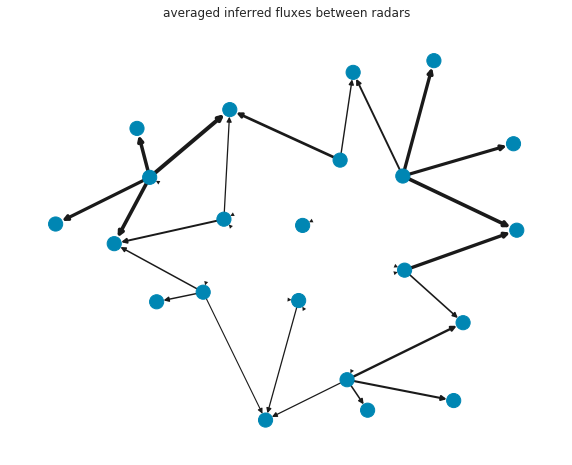

In [30]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes_boundary_fluxmlp, results_boundary_fluxmlp, trial=0)

In [32]:
for i, j, data in G_new.edges(data=True):
    print(G_new.nodes(data=True)[i]['radar'], G_new.nodes(data=True)[j]['radar'], data['flux'])

nldbl bezav 0.0005459356
nldbl bejab 0.00048271788
nldbl deemd 0.0006001839
nldbl nldhl 0.00052590057
deess nldbl 4.6120734e-09
deess bezav 0.0002937008
deess denhb 1.6814852e-09
deess deemd 0.00019169529
dehnr deess 1.2047441e-07
dehnr deboo 0.00020978875
dehnr deemd 0.0004061124
defld deneu 2.450164e-09
deumd depro 0.00047413082
deumd defld 1.8976761e-08
deumd deros 0.0004984978
deumd dedrs 0.0005441376
deumd deboo 0.00028682657
deneu deeis 0.00024298325
deneu dedrs 0.0004985761
deneu detur 3.1275622e-08
deoft deneu 1.6478554e-08
deoft deess 1.4222161e-07
deoft defbg 0.00018902129
detur deeis 0.00035795823
detur deoft 2.2419801e-08
detur deisn 0.0003138429
detur defbg 0.00018491862
detur demem 0.00023580728
denhb bezav 0.00022491033
denhb deoft 2.338065e-09
denhb bewid 0.0002188463
denhb defbg 0.00016523623


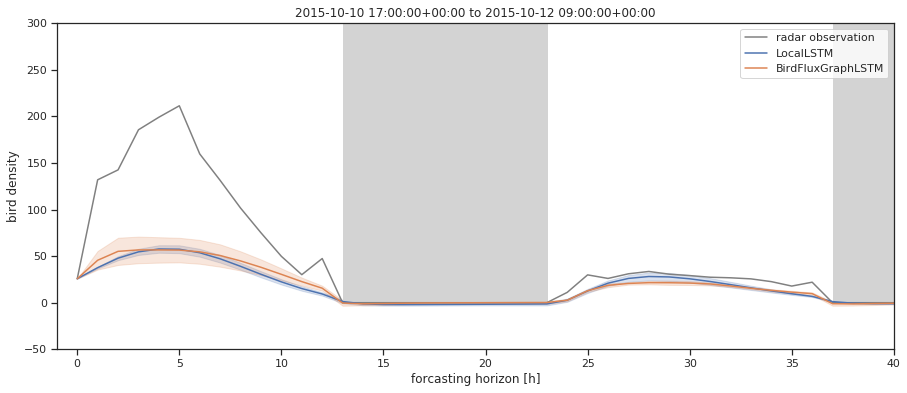

In [25]:
fig = utils.plot_example_prediction(results_boundary_fluxmlp, 'denhb', 44, max=300, min=-50)